In [1]:
%config InlineBackend.figure_formats = ['svg']
import json
import cvxpy as cp
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 200)
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
from ed_institutions import load_ed_institutions
from harvard_scorecards import load_harvard_scenarios

## What the model is doing

The COVID-19 crisis is expected to [cause a significant strain](https://covid19.healthdata.org/) on hospitals in the United States. Under normal circumstances, [about 70% of beds are in use at any given time in an urban hospital.](https://www.beckershospitalreview.com/patient-flow/capacity-dashboard-52-statistics-on-u-s-hospital-capacity.html) Hospitals will need to add auxiliary beds to handle the massive influx of COVID-19 patients expected in the coming months while continuing to offer care to non-COVID-19 patients. Additionally, many health care professionals may need to live away from their families during the peak of the COVID-19 crisis, as the disease is highly contagious. Tufts president Tony Monaco has suggested using the dormitory capacity at universities that have dedensified their campuses by sending most undergraduate students home to help fill this need. Some recovering COVID and non-COVID patients alike can be housed in dorms if they do not require specialized, intensive care; dormitory housing is also adequate for health care professionals.

This notebook seeks to verify the logistical thesis of President Monaco's proposal: **In Massachusetts, are there enough dormitory beds in close proximity to hospitals to significantly alleviate the burden on hospitals at the peak of the COVID crisis?** The raw bed counts of university dormitories far exceed those of hospitals in Massachusetts; while this is true throughout the country, Massachusetts is particularly notable as a national and global center of higher education. However, for Monaco's proposal to be feasible, we must also check that the spatiality of hospitals and universities is closely aligned enough that it is convenient to move patients and staff back and forth.

Our model uses an optimization algorithm to move beds from hospitals to universities such that the average distance between a bed's origin (a hospital) and its destination (a university) is minimized. We currently only consider recovering non-COVID patients and health care professionals; modeling for recovering COVID patients is forthcoming.

## Assumptions and choices
* Our model primarily considers acute-care hospitals—psychiatric hospitals are not currently included. Rehabilitation hospitals are included, but will likely be removed in the near future unless explicitly included on a case-by-case basis.

* It is unclear what percentage of beds each university may be able to offer to hospitals. At Tufts, approximately 90% of beds are currently open after dedensification. However, it is unrealistic to assume that every open bed can be used—for instance, efficiency may be reduced by the presumed need to keep patients, health care professionals, and remaining students in separate buildings. Furthermore, social distancing measures may prevent full utilization within a single dormitory. Outputs of our model at 40%, 60%, and 80% maximum bed utilization across all universities are similar, and our model can easily be refined to include actual available bed counts as they become available from participating universities.

* It is clearly inefficient to allocate just a few beds to a university when it is not absolutely necessary, so our model allocates beds such that every university is either entirely unused or is used with a minimum of 5% bed utilization.

* We currently filter out universities with fewer than 500 beds.

* To estimate the number of beds needed for health care professionals, we assume a 40-hour workweek and assume that each patient recieves 12 person-hours of care per day, such that 2.1 workers are devoted to every patient. Multiplying this factor by the number of available beds in each hospital (under the assumption of 100% bed utilization at every hospital during the peak of the COVID crisis). We then assume that 50% of health care professionals will decide to isolate from their families in a dormitory. This is an upper bound—Mike Apkon estimates that between 5% and 50% of professionals will actually decide to do so.

* We assume that only 50% of non-COVID patients can be moved from a hospital to a university.

[more to come]

In [38]:
# Tufts has ~90% of beds left right now (without accounting for inaccessible dorms?)
# [Unknown] Is ~80% capacity over all universities a reasonable estimate?
ed_inst_max_utilization = 0.6
ed_inst_min_utilization = 0.05
# This parameterization gives us ~35 universities.
ed_inst_min_beds = 500
ed_inst_min_endowment = 50000000
# Per Mike Apkon: each patient receives 12 person-hours of care per day (under normal conditions).
# Assuming a 40-hour workweek, this implies 1.5 staff members are fully allocated to each patient on each day.
# (Note: does this average include ICU patients? Presumably they get more care.)
# General consensus seems to be that care per patient will *decrease* as hospitals get overloaded with COVID cases,
# so consider staffing estimates to be an upper bound.
staff_hours_per_day = 8
staff_days_per_week = 5
patient_person_hours_per_day = 12
staff_per_patient = (patient_person_hours_per_day * 7) / (staff_hours_per_day * staff_days_per_week)
# [Unknown] What percentage of non-COVID patients can be moved into a dorm?
# (This parameter also encapsulates the fact that most patients probably need to present at the hospital
#  and *then* moved to the dorms.)
patient_bed_demand_pct = 0.5
# [Unknown] What percentage of staff will want to stay in a dorm rather than going home?
staff_bed_demand_pct = 0.3
# [Unknown] We assume that staff is assigned to 100% of hospital+ICU beds at the peak of the outbreak.
staff_utilized_pct = 1

# TODO: not entirely sure of the relevance of these fudge factors -- 
#       shouldn't we just be able to get discharge rates empirically?
community_discount = 0.5  # Apkon: Discount community hospital discharge rates by 50%
academic_discount = 0.75  # Apkon: Discount academic hospital discharge rates by 75%

# TODO: choose some reasonable parameters here! may need to do some sensitivity analysis
staff_transport_cost_per_min = 1
patient_transport_cost_per_min = 100

# TODO: max distance cutoffs not implemented yet
max_patient_dist_min = 30
max_staff_dist_min = 60

crisis_length = 14  # in days
staff_commutes = 2 * (crisis_length / staff_days_per_week)

In [3]:
# Ballpark parameters (to be replaced when more data comes in)
avg_stay_days = 5
patient_turnover = crisis_length / avg_stay_days
# Normally, ~70% of beds are utilized in MA.
normal_beds_utilized_pct = 0.7 

In [4]:
# Which Harvard Global Health COVID scenario should be used?
covid_scenario = '20_infected_6mo'

In [5]:
proj = "+proj=utm +zone=18N +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
acute_care_gdf = gpd.read_file('data/MA_Hospitals/Originals/acute_care_hospitals/HOSPITALS_PT.shp').to_crs(proj)
non_acute_care_gdf = gpd.read_file('data/MA_Hospitals/Originals/non_acute_care_hospitals/HOSPITALS_NONACUTE_PT.shp').to_crs(proj)
state_outlines_gdf = gpd.read_file('data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp').to_crs(proj)
ed_inst_gdf = gpd.read_file('data/Universities/SHP_dormcap/ma_universities.shp').to_crs(proj)
ma_outline_gdf = state_outlines_gdf[state_outlines_gdf['NAME'] == 'Massachusetts']

In [6]:
travel_time_df = pd.read_csv('data/schools_to_hospitals.csv')

In [7]:
#ed_inst_df = load_ed_institutions('data/ma_dorm_capacity.csv', ed_inst_min_endowment, 0)
#ed_inst_gdf = ed_inst_gdf[ed_inst_gdf.COLLEGE.isin(ed_inst_df.name)]
ed_inst_gdf = ed_inst_gdf[ed_inst_gdf['DORMCAP'] >= ed_inst_min_beds]

In [8]:
# Fix irregularities in NEU data and remove satellite BC campuses
ed_inst_gdf = ed_inst_gdf[((ed_inst_gdf['COLLEGE'] != 'Northeastern University') &
                          (ed_inst_gdf['COLLEGE'] != 'Boston College')) | 
                          (ed_inst_gdf['CAMPUS'] == 'Main Campus')]
ed_inst_gdf = ed_inst_gdf.reset_index()

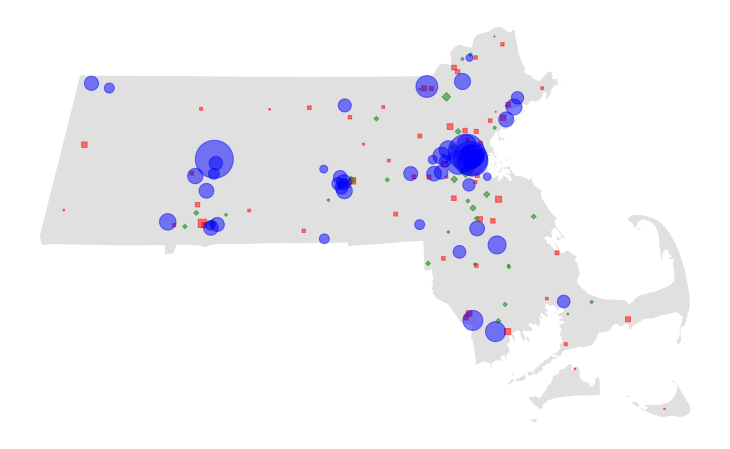

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
base = ma_outline_gdf.plot(ax=ax, color='#e0e0e0')
acute_care_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                    markersize=0.1 * acute_care_gdf['BEDCOUNT'])
non_acute_care_gdf.plot(ax=base, marker='D', color='green', alpha=0.5,
                        markersize=0.1 * non_acute_care_gdf['BEDCOUNT'])
ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                 markersize=0.1 * ed_inst_gdf['DORMCAP'])
plt.axis('off')
plt.savefig('ma_beds.png', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
travel_time_available = travel_time_df[' Destination'].unique()

# We treat acute care hospitals and non-acute care hospitals similarly. 
acute_care_gdf['TYPE'] = 'acute'
non_acute_care_gdf['TYPE'] = 'non-acute'
non_acute_care_gdf = non_acute_care_gdf.rename(columns={'FAC_NAME': 'SHORTNAME'})
hospitals_gdf = gpd.GeoDataFrame(pd.concat([
    acute_care_gdf,
    non_acute_care_gdf
])).drop(columns=set(acute_care_gdf.columns) - set(non_acute_care_gdf.columns)) \
.rename(columns={'SHORTNAME': 'NAME'})

# Remove island hospitals from consideration (not accessible by road)
hospitals_gdf = hospitals_gdf[(hospitals_gdf['TOWN'] != 'Oak Bluffs') & (hospitals_gdf['TOWN'] != 'Nantucket')]
# Remove hospitals where travel time is unavailable.
hospitals_gdf = hospitals_gdf[hospitals_gdf['NAME'].isin(travel_time_available)]

# Remove some non-acute care hospitals from consideration
hospitals_gdf = hospitals_gdf[hospitals_gdf['TYPE'] != 'Psychiatric Hospital']

hospitals_gdf = hospitals_gdf.reset_index()
# TODO: Remove hospitals not within X miles/minutes of an institution?

In [11]:
non_acute_care_gdf

,IDNUMBER,SHORTNAME,ADDRESS,TOWN,GEOG_TOWN,ZIPCODE,CHIAREGION,TELEPHONE,COHORT,HOSPSYSTEM,TAXSTATUS,BEDCOUNT,MADID,EMSREGION,geometry,TYPE
0,2202,AdCare Hospital of Worcester,107 Lincoln Street,Worcester,WORCESTER,01605,Central Massachusetts,(508) 799-9000,Specialty Hospital,AdCare Health Systems,For profit,114,1366126,2,POINT (764291.511 4685438.625),non-acute
1,2290,Hebrew Rehabilitation Center,1200 Centre Street,Boston,BOSTON,02131,Metro Boston,(617) 363-8000,Specialty Hospital,Hebrew SeniorLife,Non-profit,717,35027533,4,POINT (818973.711 4689972.151),non-acute
2,2837,Bournewood Hospital,300 South Street,Brookline,BROOKLINE,02167,Metro Boston,(617) 469-0300,Psychiatric Hospital,AtitaCare,For profit,90,3320480,4,POINT (817434.415 4690113.123),non-acute
3,2821,Lemuel Shattuck Hospital,170 Morton Street,Boston,BOSTON,02130,Metro Boston,(617) 522-8110,State Multi-Specialty Hospital,Bureau of Hospitals,Public,255,35341854,4,POINT (821333.030 4690404.281),non-acute
4,2836,Arbour Hospital,49 Robinwood Avenue,Boston,BOSTON,02130,Metro Boston,(617) 522-4400,Psychiatric Hospital,Universal Health Service,For profit,136,35117474,4,POINT (820400.726 4692161.680),non-acute
5,2221,Franciscan Children’s,30 Warren Street,Boston,BOSTON,02135,Metro Boston,(617) 254-3800,Specialty Hospital,<Null>,Non-profit,112,35143241,4,POINT (822730.326 4693829.215),non-acute
6,2D9E,Dr. Solomon Carter Fuller Mental Health Center,85 East Newton Street,Boston,BOSTON,02118,Metro Boston,(617) 626-8700,Psychiatric Hospital,Mass. Dept. of Mental Health,Public,60,35157229,4,POINT (823697.362 4694607.971),non-acute
7,2327,HRI Hospital,227 Babcock Street,Brookline,BROOKLINE,02146,Metro Boston,(617) 731-3200,Psychiatric Hospital,Universal Health Service,For profit,62,3312013,4,POINT (819488.501 4696014.377),non-acute
8,2ADW,Walden Behavioral Care,51 Sawyer Road,Waltham,WALTHAM,02453,Metro Boston,(781) 647-6700,Psychiatric Hospital,Walden Behavioral Care INC,For profit,47,2836660,4,POINT (808830.898 4697563.766),non-acute
9,2102,Spaulding Hospital for Continuing Medical Care...,1575 Cambridge Street,Cambridge,CAMBRIDGE,02138,Metro Boston,(617) 876-4344,Chronic Care Hospital,Partners HealthCare System,Non-profit,180,3628145,4,POINT (820511.707 4698817.932),non-acute


In [12]:
harvard_scenarios = load_harvard_scenarios('data/HarvardGlobalHealth/')
bg_vulnerability = json.load(open('data/ma_bg_vulnerability.json'))
bg_gdf = gpd.read_file('data/tl_2017_25_bg/tl_2017_25_bg.shp').to_crs(proj)
pop_by_bg_id = {bg: bg_data['total_pop'] for bg, bg_data in bg_vulnerability.items()}

In [13]:
bg_pop_col = []
for _, row in bg_gdf.iterrows():
    bg_pop_col.append(pop_by_bg_id[row['GEOID']])
bg_gdf['population'] = bg_pop_col

In [14]:
statewide_covid_beds = harvard_scenarios[covid_scenario]['total_hosp_beds'].sum()
covid_beds_per_capita = statewide_covid_beds / bg_gdf['population'].sum()
bg_gdf['covid_beds'] = bg_gdf['population'] * covid_beds_per_capita

In [15]:
covid_beds_per_capita

0.00195484959209791

**Some stub code above is intended for use with a model that maps block groups to hospitals in an informed way (based on vulnerability, closeness, etc.) For now, let's just assume that hospitals are uniformly overloaded.**

In [16]:
# TODO: what about ICU beds? (oftentimes we don't get differentiated counts)
hosp_beds_used_pct = (1 - patient_bed_demand_pct) * normal_beds_utilized_pct
hosp_beds_available = hospitals_gdf['BEDCOUNT'].sum() * (1 - hosp_beds_used_pct)
overload_factor = statewide_covid_beds / hosp_beds_available

In [17]:
overload_factor

1.0339006674823061

In [18]:
n_hosp = len(hospitals_gdf)
n_ed = len(ed_inst_gdf)

In [19]:
euclidean_distances = np.zeros((n_hosp, n_ed))
for hosp_idx, hosp_row in hospitals_gdf.iterrows():
    for ed_idx, ed_row in ed_inst_gdf.iterrows():
        dist = hosp_row.geometry.distance(ed_row.geometry)
        euclidean_distances[hosp_idx, ed_idx] = dist

In [20]:
travel_time_distances = np.zeros((n_hosp, n_ed))  # in minutes

#for hosp_idx, hosp_row in hospitals_gdf.iterrows():
#    for ed_idx, ed_row in ed_inst_gdf.iterrows():
#        travel_row = travel_time_df[(travel_time_df['Source'] == ed_row['COLLEGE']) &
#                                    (travel_time_df[' Destination'] == hosp_row['NAME'])]
#        travel_time_distances[hosp_idx, ed_idx] = travel_row[' Driving Time (s)'] / 60

In [21]:
np.sort(travel_time_distances.min(axis=1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
distances = euclidean_distances

In [23]:
dorm_bed_capacity = np.round(ed_inst_max_utilization * ed_inst_gdf['DORMCAP'].to_numpy())
patient_bed_demand = np.round(normal_beds_utilized_pct * patient_bed_demand_pct * hospitals_gdf['BEDCOUNT'].to_numpy())
staff_bed_demand = np.round(staff_per_patient * staff_bed_demand_pct * staff_utilized_pct * hospitals_gdf['BEDCOUNT'].to_numpy())

In [24]:
staff_assignment = cp.Variable((n_hosp, n_ed))
patient_assignment = cp.Variable((n_hosp, n_ed))

In [25]:
constraints = [
    staff_assignment >= 0,
    patient_assignment >= 0,
    cp.sum(staff_assignment, axis=0) + cp.sum(patient_assignment, axis=0) <= dorm_bed_capacity,
    cp.sum(staff_assignment, axis=1) == staff_bed_demand,
    cp.sum(patient_assignment, axis=1) == patient_bed_demand,
]
objective = cp.Minimize(cp.sum(
    cp.multiply(distances, (
        (staff_commutes * staff_transport_cost_per_min * staff_assignment) + 
        (patient_turnover * patient_transport_cost_per_min * patient_assignment)
    ))
))

In [26]:
worst_utilization = 0
worst_utilization_idx = None

while worst_utilization < ed_inst_min_utilization:
    if worst_utilization_idx is not None:
        print('Eliminating', ed_inst_gdf.iloc[worst_utilization_idx]['COLLEGE'])
        dorm_bed_capacity[worst_utilization_idx] = 0
    
    prob = cp.Problem(objective, constraints=constraints)
    prob.solve()
    staff_results = np.round(staff_assignment.value)
    patient_results = np.round(patient_assignment.value)
    staff_by_inst = np.sum(staff_results, axis=0)
    patients_by_inst = np.sum(patient_results, axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        utilization = (staff_by_inst + patients_by_inst) / dorm_bed_capacity
    utilization[np.isnan(utilization)] = 1
    utilization[utilization == 0] = 1
    worst_utilization = np.min(utilization)
    worst_utilization_idx = np.argmin(utilization)

Eliminating University of Massachusetts Amherst
Eliminating Brandeis University
Eliminating Harvard College
Eliminating Massachusetts Institute of Technology
Eliminating Boston University
Eliminating Assumption College


In [27]:
def plot_assignments(results):
    fig, ax = plt.subplots(figsize=(16, 8))
    base = ma_outline_gdf.plot(ax=ax, color='#e0e0e0')
    hospitals_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                        markersize=0.1 * hospitals_gdf['BEDCOUNT'])
    ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                     markersize=0.1 * ed_inst_gdf['DORMCAP'])

    for hosp_idx in range(n_hosp):
        for ed_idx in range(n_ed):
            if results[hosp_idx, ed_idx] > 0:
                p_hosp = hospitals_gdf.iloc[hosp_idx].geometry
                p_ed = ed_inst_gdf.iloc[ed_idx].geometry
                ax.plot([p_hosp.x, p_ed.x], [p_hosp.y, p_ed.y],
                        color='black',
                        linewidth=0.01 * results[hosp_idx, ed_idx])
                
    plt.axis('off')

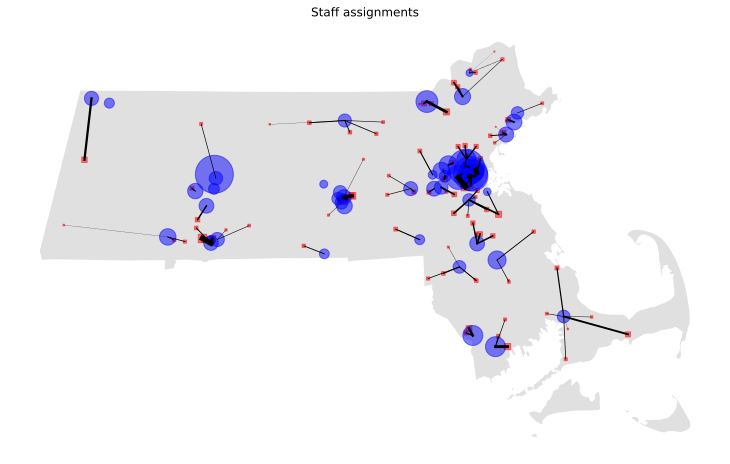

In [28]:
plot_assignments(staff_results)
plt.title('Staff assignments')
plt.savefig('ma_staff_assignments_travel_time.png', bbox_inches='tight', dpi=600)
plt.show()

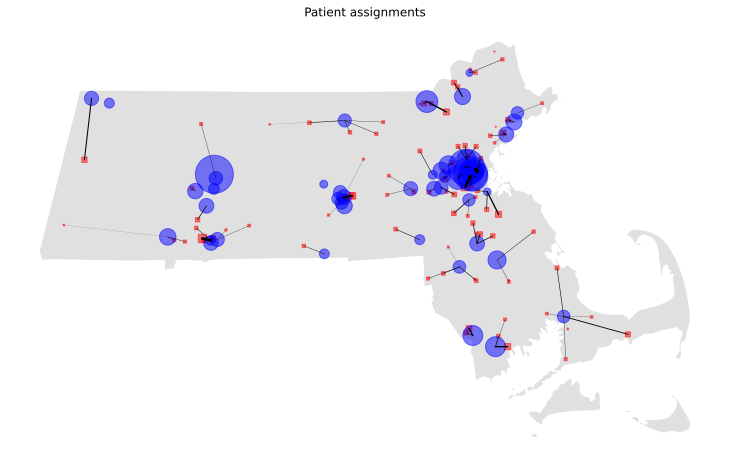

In [29]:
plot_assignments(patient_results)
plt.title('Patient assignments')
plt.savefig('ma_patient_assignments_travel_time.png', bbox_inches='tight', dpi=600)
plt.show()

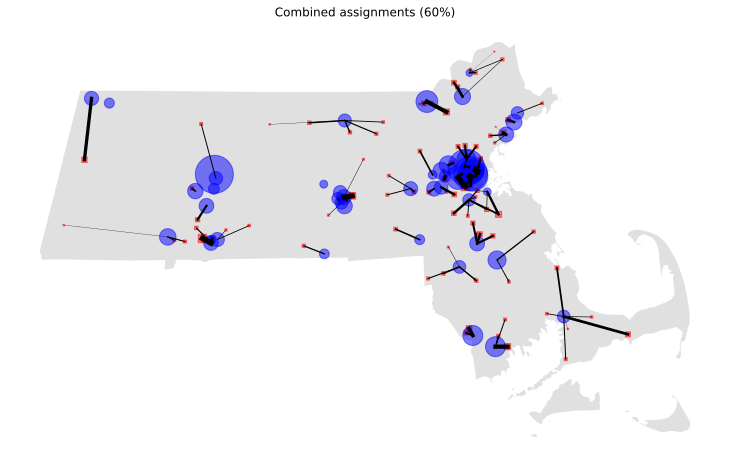

In [30]:
plot_assignments(staff_results + patient_results)
plt.title('Combined assignments (60%)')
plt.savefig('ma_combined_assignments_travel_time_60.png', bbox_inches='tight', dpi=600)
plt.show()

In [31]:
def save_assignments(results, filename):
    assignments = []
    for hosp_idx, hosp_row in hospitals_gdf.iterrows():
        for ed_idx, ed_row in ed_inst_gdf.iterrows():
            if results[hosp_idx, ed_idx] > 0:
                assignments.append({
                    'college': ed_row['COLLEGE'],
                    'hospital': hosp_row['NAME'],
                    'weight': results[hosp_idx, ed_idx]
                })
    with open(filename, 'w') as f:
        json.dump(assignments, f)

In [32]:
save_assignments(patient_results + staff_results, 'ma_combined_results_20200325_v4.json')

In [33]:
staff_by_inst = np.sum(staff_results, axis=0)
patients_by_inst = np.sum(patient_results, axis=0)
ed_assignment_df = ed_inst_gdf[['COLLEGE', 'CITY', 'DORMCAP']].copy()
ed_assignment_df = ed_assignment_df.rename(columns={
    'COLLEGE': 'Name',
    'CITY': 'City',
    'DORMCAP': 'Beds'
})
ed_assignment_df['Hospital staff'] = staff_by_inst.astype(int)
ed_assignment_df['Patients'] = patients_by_inst.astype(int)
utilization_rounded = (1000 * (ed_assignment_df['Hospital staff'] + ed_assignment_df['Patients']) / ed_assignment_df['Beds']).astype(int)
ed_assignment_df['Utilization (%)'] = utilization_rounded / 10.0 
ed_assignment_df.to_csv('ma_ed_inst_assignments_20200325_v4.csv', index=False)

**A question from Moon: how often are universities split between hospital systems?**

In [34]:
university_systems = {}
all_results = staff_results + patient_results
for ed_idx, ed_row in ed_inst_gdf.iterrows():
    university_systems[ed_row['COLLEGE']] = defaultdict(int)
    for hosp_idx, hosp_row in hospitals_gdf.iterrows():
        if all_results[hosp_idx, ed_idx] > 0:
            university_systems[ed_row['COLLEGE']][hosp_row['HOSPSYSTEM']] += all_results[hosp_idx, ed_idx]

In [35]:
university_systems

{'Massachusetts Maritime Academy': defaultdict(int,
             {'Cape Cod Healthcare': 381.0,
              'Not Applicable': 82.0,
              'CareGroup': 176.0,
              'Mass. Dept. of Mental Health': 26.0,
              'Partners HealthCare System': 66.0}),
 'Wheaton College': defaultdict(int,
             {'Steward Health Care System': 138.0,
              'Not Applicable': 145.0,
              'Mass. Dept. of Mental Health': 50.0,
              'Universal Health Service': 112.0,
              'Steward Health Care': 47.0}),
 'Bridgewater State University': defaultdict(int,
             {'Southeast Regional Network': 79.0,
              'Partners HealthCare System': 32.0,
              'Universal Health Service': 132.0}),
 'Nichols College': defaultdict(int, {'Not Applicable': 126.0}),
 'Stonehill College': defaultdict(int,
             {'Not Applicable': 217.0,
              'Steward Health Care System': 246.0,
              'Curahealth': 97.0,
              'Steward Hea

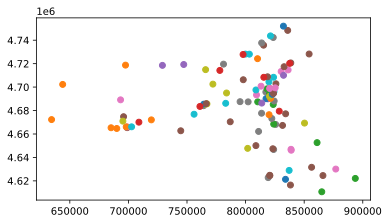

In [36]:
hospitals_gdf.plot(column='HOSPSYSTEM')

In [37]:
hospitals_gdf['HOSPSYSTEM'].value_counts()

Not Applicable                    19
Partners HealthCare System        12
Steward Health Care System         9
CareGroup                          7
Wellforce                          5
Mass. Dept. of Mental Health       5
UMass Memorial Health Care         5
Encompass Health                   4
Bureau of Hospitals                4
Baystate Health                    4
Lahey Health System                4
Tenet Healthcare                   3
Universal Health Service           3
Vibra Healthcare                   3
Hebrew SeniorLife                  2
Whittier Health System             2
Shriners Hospital for Children     2
<Null>                             2
Berkshire Health Systems           2
Heywood Healthcare                 2
Steward Health Care                2
HealthSouth                        2
Cape Cod Healthcare                2
AdCare Health Systems              1
Health Partners New England        1
Acadia Healthcare                  1
AtitaCare                          1
L